In [10]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.distributions import Distribution, Uniform
from torch.distributions.transforms import SigmoidTransform, AffineTransform
from torch.distributions import TransformedDistribution

class Logistic(TransformedDistribution):
    def __init__(self, loc, scale, validate_args=None):
        self.loc = loc
        self.scale = scale
        base_distribution = Uniform(torch.Tensor([0]).to(loc.device), torch.Tensor([1]).to(loc.device))
        transforms = [SigmoidTransform().inv, AffineTransform(loc=loc, scale=scale)]
        super().__init__(base_distribution, transforms, validate_args=validate_args)

In [2]:
z_size = 100
logits = torch.randn(1, z_size)
logits.requires_grad = True

# Random nonlinear f
g = torch.nn.Linear(z_size, 1)
f = lambda x: torch.sigmoid(g(x))

## ARM 1

$\nabla_\theta \mathbb{E}_{q_\theta(b)}[f(b)] = \frac{1}{2} \left(f(\mathbb{1}_{z > 0}) - f(\mathbb{1}_{\tilde{z} > 0}) \right) \nabla_\theta \log q_\theta(z)$

## ARM 2
$\nabla_\theta \mathbb{E}_{q_\theta(b)}[f(b)] = \frac{1}{2} \left(f(\mathbb{1}_{z > 0}) - f(\mathbb{1}_{\tilde{z} > 0}) \right) (2u - 1) \nabla_\theta \alpha_\theta$

Where
$u = \sigma(z - \alpha_\theta) = \sigma(\epsilon)$

In [3]:
def grad_arm_1(logits, f):
    logits.grad = None
    q_z = Logistic(logits, torch.Tensor([1.]).to(logits.device))
    with torch.no_grad():
        u = torch.rand(logits.size())
        eps = torch.logit(u)
        z = logits + eps
        z_ = logits - eps
        r = f((z > 0.).float())
        r_ = f((z_ > 0.).float())
        reward = 0.5 * (r - r_)
    loss = (reward * q_z.log_prob(z)).sum(-1)
    return torch.autograd.grad(loss.mean(), logits)[0].detach()

def grad_arm_2(logits, f):
    logits.grad = None
    with torch.no_grad():
        u = torch.rand(logits.size())
        eps = torch.logit(u)
        r = f((logits + eps > 0.).float())
        r_ = f((logits - eps > 0.).float())
        reward = 0.5 * (r - r_).unsqueeze(-1) * (2 * u - 1)
    loss = (reward * logits).sum(-1)
    return torch.autograd.grad(loss.mean(), logits)[0].detach()

torch.manual_seed(1)
grad_1 = grad_arm_1(logits, f)
torch.manual_seed(1)
grad_2 = grad_arm_2(logits, f)
print(torch.allclose(grad_1, grad_2), torch.abs(grad_1 - grad_2).mean())

%timeit grad_arm_1(logits, f)
%timeit grad_arm_2(logits, f)

True tensor(1.1503e-09)
497 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
257 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## DisARM

$\nabla_\theta \mathbb{E}_{q_\theta(b)}[f(b)] = \frac{1}{2} \left(f(b) - f(\tilde{b}) \right) \left((-1)^{\tilde{b}} \mathbb{1}_{b_i \neq \tilde{b}_i} \sigma(|(\alpha_\theta)_i|)\right) \nabla_\theta (\alpha_\theta)_i$

In [4]:
def grad_disarm(logits, f):
    logits.grad = None
    with torch.no_grad():
        eps = torch.logit(torch.rand(logits.size()))
        b = (logits + eps > 0.).float()
        b_ = (logits - eps > 0.).float()
        r = f(b)
        r_ = f(b_)
        s = torch.pow(-1, b_) * (~torch.eq(b, b_)).float() * torch.sigmoid(torch.abs(logits))
        reward = 0.5 * (r - r_).unsqueeze(-1) * s
    loss = (reward * logits).sum(-1)
    return torch.autograd.grad(loss.mean(), logits)[0].detach()

grad_disarm(logits, f)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0228,  0.0228, -0.0276, -0.0295, -0.0302,
          0.0338,  0.0000,  0.0311, -0.0288,  0.0328, -0.0297,  0.0264,  0.0289,
         -0.0341,  0.0000,  0.0219, -0.0231, -0.0217,  0.0000, -0.0237,  0.0000,
         -0.0314,  0.0000,  0.0242,  0.0000,  0.0000, -0.0220, -0.0225,  0.0230,
          0.0233, -0.0352,  0.0000,  0.0251,  0.0239,  0.0000,  0.0235,  0.0000,
         -0.0253, -0.0318, -0.0270,  0.0306,  0.0000,  0.0000,  0.0222, -0.0247,
         -0.0309,  0.0253, -0.0226,  0.0000,  0.0229,  0.0314, -0.0293,  0.0000,
          0.0268,  0.0000, -0.0249, -0.0278, -0.0271,  0.0000,  0.0394,  0.0336,
         -0.0265, -0.0304,  0.0219,  0.0355,  0.0000,  0.0257,  0.0000,  0.0000,
         -0.0297,  0.0000,  0.0000,  0.0000,  0.0000, -0.0259,  0.0259,  0.0000,
          0.0000,  0.0301,  0.0250,  0.0000,  0.0000, -0.0215,  0.0315,  0.0000,
         -0.0225,  0.0234,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0238,
          0.0221,  0.0000,  

In [15]:
z_size = 100
logits = torch.randn(1, z_size)
logits.requires_grad = True

# Random nonlinear f
g = torch.nn.Linear(z_size, 1)
f = lambda x: torch.sigmoid(g(x))

grads_arm = []
grads_disarm = []
iters = 20000
for _ in range(iters):
    grads_arm.append(grad_arm_2(logits, f))
    grads_disarm.append(grad_disarm(logits, f))
    
grads_arm = torch.cat(grads_arm, 0)
grads_disarm = torch.cat(grads_disarm, 0)

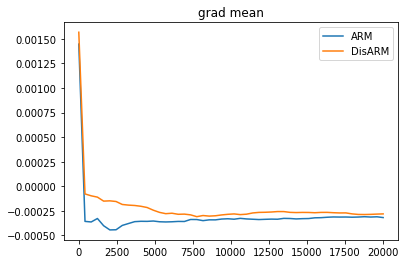

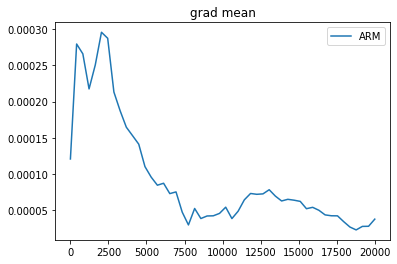

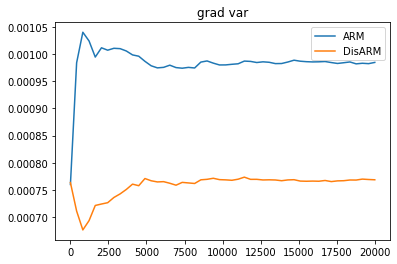

In [16]:
arm_means, arm_vars = [], []
disarm_means, disarm_vars = [], []
n = torch.linspace(5, iters, 50)
for i in n:
    arm_mean, arm_var = grads_arm[:int(i)].mean(), grads_arm[:int(i)].var(0).mean()
    arm_means.append(arm_mean)
    arm_vars.append(arm_var)
    disarm_mean, disarm_var = grads_disarm[:int(i)].mean(), grads_disarm[:int(i)].var(0).mean()
    disarm_means.append(disarm_mean)
    disarm_vars.append(disarm_var)
 
plt.title('grad mean')
plt.plot(n, arm_means, label="ARM")
plt.plot(n, disarm_means, label="DisARM")
plt.legend()
plt.show()

plt.title('grad mean')
plt.plot(n, np.abs(np.array(arm_means) - np.array(disarm_means)), label="ARM")
plt.legend()
plt.show()

plt.title('grad var')
plt.plot(n, arm_vars, label="ARM")
plt.plot(n, disarm_vars, label="DisARM")
plt.legend()
plt.show()